In [121]:
import tensorflow
import numpy
import pandas
import matplotlib
import json
import re

print(tensorflow.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.6.0
1.21.4
1.3.3
3.4.3
2.0.9
2.2.1


### vocab_size = 8000의 spm tokenizer 생성

In [125]:
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']


## 2. 데이터 전처리 (1) MASK 생성

MLMtask 수행을 위한 마스크 생성 함수 정의

In [126]:
import random

def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """    
    cand_index = []
    for i, token in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_index) and not token.startswith(u"\u2581"):
            cand_index[-1].append(i)
        else:
            cand_index.append([i])
            
    random.shuffle(cand_index)
        
    mask_lms = []
        
    for i in cand_index:
        if len(mask_lms) >= mask_cnt:
            break
        if len(mask_lms) + len(i) > mask_cnt:
            continue
            
        dice = random.random()
            
        for index in i:
            maked_token = None
            if dice < 0.8:
                masked_token = "[MASK]"
            elif dice < 0.9: 
                masked_token = tokens[index]
            else:  
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
                
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]
    mask_label = [p["label"] for p in mask_lms]
            
    return tokens, mask_idx, mask_label
            

들여쓰기 실수로 mask위치가 고정되어 있는 오류를 수정

In [127]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
import copy
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
mask_cnt
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]']
tokens_org
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '▁그날', '은', '▁', '왠', '지', '▁손', '님이', '▁많아', '▁첫', '▁번에', '▁삼', '십', '▁전', '▁둘째', '번', '▁오', '십', '▁전', '▁오랜', '만에', '▁받아', '보는', '▁십', '▁전', '짜리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손바닥', '▁위', '엔', '▁기쁨', '의', '▁눈', '물이', '▁흘러', '▁컬', '컬', '한', '▁목에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전부터', '▁콜', '록', '거리는', '▁아내', '▁생각에', '▁그', '토록', '▁먹고', '▁싶다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추적', '추', '적', '▁비가', '▁내리는', '▁날', '이었', '어', '[M

### 문장에서 _추적을 정확히 마스킹하고 몇번째 인덱스가 마스킹되었는지 잘 가르킴

## 3. 데이터 전처리 (2) NSP pair 생성

문장의 길이가 max를 넘어갈 때 잘라주는 함수

In [128]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

NSP 수행을 위한 pair 생성함수 정의

In [129]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    :param vocab: 어휘 사전 (여기서는 사용되지 않음. `vocab_list`가 사용됨)
    :param doc: 입력 문서 (문장들의 리스트)
    :param n_seq: 최대 시퀀스 길이 (BERT 모델 입력 시퀀스의 최대 길이)
    :param mask_prob: 마스킹할 토큰의 비율 (MLM을 위해 사용)
    :param vocab_list: 마스킹 시 랜덤 토큰을 선택하기 위한 어휘 리스트
    :return instances: 생성된 pretrain 인스턴스들의 리스트
    """
    
    max_seq = n_seq - 3
    
    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (1 == len(doc) - 1 or current_length >= max_seq):
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1,len(current_chunk))
            tokens_a = []                      
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            tokens_b = []
            for j in range(a_end,len(current_chunk)):
                tokens_b.extend(current_chunk[j])
            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0     #False (NotNextSentence)
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1    #True (IsNextSentence)
                # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)

            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            # 다음 인스턴스 생성을 위해 current_chunk 초기화
            current_chunk = []
            current_length = 0

    return instances

## 4. 데이터 전처리 (3) 데이터셋 완성

In [130]:
from tqdm.notebook import tqdm

데이터 토큰화 및 마스크,페어 함수

In [131]:
def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

라인 수 체크

In [133]:
# 라인수
total = 0
with open(pretrain_json_path, "r") as f:
    for line in f:  
        total += 1
total

746274

In [134]:
import numpy as np
n_seq = 128
# [CLS], tokens_a, [SEP], tokens_b, [SEP]
max_seq = n_seq - 3

# 만약 일반적인 Numpy Array에다 데이터를 로딩한다면 이렇게 되겠지만
# enc_tokens = np.zeros((total, n_seq), np.int32)
# dec_tokens = np.zeros((total, n_seq), np.int32)
# labels_nsp = np.zeros((total,), np.int32)
# labels_mlm = np.zeros((total, n_seq), np.int32)

# np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))


enc_tokens[0], enc_tokens[-1], segments[0], segments[-1], labels_nsp[0], labels_nsp[-1], labels_mlm[0], labels_mlm[-1]

(memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32),
 memmap([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0

학습에 필요한 데이터를 로딩하는 함수

In [135]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)
     

In [137]:
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

(memmap([    5, 16415, 25250,  3324,  1042,   103, 27610, 27686, 27718,
         25250,     6,     6,     6,     6,   131, 27662,     7, 27629,
           203,   241, 27602,  4867,   788,   243,  5898,   796,   663,
          1647,  4630, 27625,   203,  3008, 27625, 27616,    16, 27599,
             4, 16415,   207,  4612,  5551, 27646,   630, 27714,  4269,
           429,  5346, 27626, 14406,  1605, 27599,  5551, 14146, 15991,
          8637, 27599,    13,    81,     6,  2247, 15033, 27873, 14475,
         27813, 27873, 28196, 27636, 10185, 16285,  1232,     6,     6,
          4777, 27625,   243,  2780,    14,  1509, 22095,   414,   165,
          1697, 28290, 27873, 27703, 27683,   593,     6,     6,     6,
          5540,   813,    17, 27599,     6, 16905,   103, 28313, 28290,
         19041, 27718,    98, 27878, 15784,  2543,   309,   337,  5771,
         27616, 27603,  4578, 27599,  3715, 27625,  5551,    37, 11234,
          2378,  5249,     6,     6,    13, 20590,  2386,  2163,

## 5. BERT 모델 구현

In [138]:
import tensorflow as tf

트랜스포머의 마스킹 함수

In [139]:
def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

활성화 함수 gelu

In [140]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer

json 데이터 설정을 위한 함수

In [141]:
class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

트랜스포머의 임베딩 레이어 해당 레이어는 다른 모듈과 공유됨

In [142]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


포지션 임베딩 함수

In [143]:
class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed


Attention 함수들

In [144]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [145]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out

FFN

In [146]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

인코더 레이어

In [147]:
class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

BERT 클래스

In [148]:
class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

NSP task 수행을 위한 헤드

In [149]:
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs

MLM,NSP 수행 종합빌드 함수

In [150]:
def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model

## 6. pretrain 진행

In [151]:
config = Config({"d_model": 256, "n_head": 4, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 3, "n_seq": 256, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 256,
 'n_head': 4,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 3,
 'n_seq': 256,
 'n_vocab': 32007,
 'i_pad': 0}

로스 함수

In [152]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

정확도 함수

In [153]:
from tensorflow.keras import backend as K

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy

In [154]:
class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

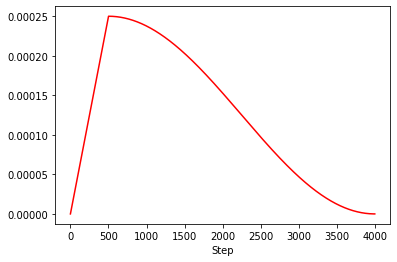

In [155]:
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

In [157]:
import math
import matplotlib.pyplot as plt

In [158]:
pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
enc_tokens (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
segments (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
bert (BERT)                     ((None, 256), (None, 10629632    enc_tokens[0][0]                 
                                                                 segments[0][0]                   
__________________________________________________________________________________________________
pooled_nsp (PooledOutput)       (None, 2)            66304       bert[0][0]                 

### 모델 컴파일 및 학습 (에폭 10, 배치사이즈 64)

In [159]:
epochs = 10
batch_size = 64

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 20000


In [160]:
# Q. 모델을 학습시키고, 내용을 history에 담아주세요.
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(
    pre_train_inputs,
    pre_train_labels,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[save_weights]
)

# 훈련된 모델 저장
pre_train_model.sava(f"{model_dir}/bert_pre_train_model.keras")
print(f"Trained model saved to {model_dir}/bert_pre_train_model.keras")

Epoch 1/10
2000/2000 [==============================] - 568s 282ms/step - loss: 23.2352 - nsp_loss: 0.6431 - mlm_loss: 22.5921 - nsp_acc: 0.6039 - mlm_lm_acc: 0.0879

Epoch 00001: mlm_lm_acc improved from -inf to 0.08793, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 2/10
2000/2000 [==============================] - 568s 284ms/step - loss: 20.7954 - nsp_loss: 0.6126 - mlm_loss: 20.1828 - nsp_acc: 0.6445 - mlm_lm_acc: 0.1224

Epoch 00002: mlm_lm_acc improved from 0.08793 to 0.12243, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 3/10
2000/2000 [==============================] - 568s 284ms/step - loss: 19.6634 - nsp_loss: 0.5860 - mlm_loss: 19.0773 - nsp_acc: 0.6895 - mlm_lm_acc: 0.1373

Epoch 00003: mlm_lm_acc improved from 0.12243 to 0.13733, saving model to /aiffel/aiffel/bert_pretrain/models/bert_pre_train.hdf5
Epoch 4/10
2000/2000 [==============================] - 568s 284ms/step - loss: 18.5731 - nsp_loss: 0.5602 - mlm

AttributeError: 'Functional' object has no attribute 'sava'

NSP,MLM 트레인 로스 시각화

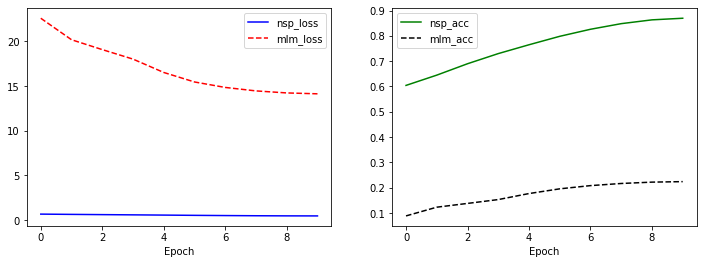

In [161]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

MLM테스크 인퍼런스

In [165]:

model_name_path = "{model_dir}/bert_pre_train.hdf5"

def predict_masked_words(sentence, model, vocab_processor, config_obj, top_k=5):
    """
    BERT 모델을 사용하여 문장 내 마스크된 단어를 예측합니다.
    :param sentence: '[MASK]' 토큰이 포함된 입력 문장 문자열.
    :param model: 훈련된 Keras BERT 모델.
    :param vocab_processor: SentencePieceProcessor 인스턴스.
    :param config_obj: 모델의 설정 객체.
    :param top_k: 각 마스크에 대해 반환할 상위 예측 개수.
    :return: 각 내부 리스트가 마스크에 대한 (토큰, 확률) 튜플을 포함하는 리스트의 리스트.
    """
    if '[MASK]' not in sentence:
        print("문장에서 [MASK] 토큰을 찾을 수 없습니다.")
        return []

    tokens = ["[CLS]"] + vocab_processor.encode_as_pieces(sentence) + ["[SEP]"]
    
    masked_indices = [i for i, token in enumerate(tokens) if token == "[MASK]"]
    if not masked_indices:
        print("경고: '[MASK]' 토큰이 여러 조각으로 토큰화되었거나 토큰화 후 찾을 수 없습니다.")
        # '[MASK]'가 user_defined_symbol이 아니거나 어휘집에 보존되는 방식으로 포함되지 않은 경우 발생할 수 있습니다.
        # 여러분의 어휘집 훈련(122번 셀)은 [MASK]를 user_defined_symbol로 포함하므로 괜찮을 것입니다.
        return []

    input_ids = [vocab_processor.piece_to_id(p) for p in tokens]
    segment_ids = [0] * len(input_ids)

    # 패딩
    padding_length = config_obj.n_seq - len(input_ids)
    if padding_length < 0:
        print(f"경고: 문장이 n_seq ({config_obj.n_seq})보다 깁니다. 자릅니다.")
        input_ids = input_ids[:config_obj.n_seq]
        segment_ids = segment_ids[:config_obj.n_seq]
        # 자르기로 인해 masked_indices가 영향을 받았다면 업데이트합니다.
        masked_indices = [idx for idx in masked_indices if idx < config_obj.n_seq]
        if not masked_indices:
             print("자르기 후 [MASK] 토큰이 남아있지 않습니다.")
             return []
    else:
        input_ids += [vocab_processor.pad_id()] * padding_length
        segment_ids += [0] * padding_length
        
    input_ids_np = np.array([input_ids])
    segment_ids_np = np.array([segment_ids])

    _, mlm_predictions = model.predict((input_ids_np, segment_ids_np), verbose=0)
    
    results = []
    for mask_idx in masked_indices:
        if mask_idx >= mlm_predictions.shape[1]: # 적절한 자르기 로직에서는 발생하지 않아야 합니다.
            continue
            
        mask_predictions = mlm_predictions[0, mask_idx, :]
        top_k_indices = np.argsort(mask_predictions)[-top_k:][::-1]
        
        top_k_tokens_probs = []
        for token_id in top_k_indices:
            token = vocab_processor.id_to_piece(int(token_id))
            prob = mask_predictions[token_id]
            top_k_tokens_probs.append((token, prob))
        results.append(top_k_tokens_probs)
        
    return results
    

### MLM 수행

In [166]:
def run_mlm_predictions(test_sentences, model, vocab_processor, config_obj, top_k=3):
    """
    테스트 문장 리스트에 대해 MLM 예측을 실행하고 결과를 출력합니다.
    """
    for sentence in test_sentences:
        print(f"입력: {sentence}")
        predictions = predict_masked_words(sentence, model, vocab_processor, config_obj, top_k=top_k)
        if predictions:
            for i, mask_preds in enumerate(predictions):
                original_mask_token = f"[MASK]_{i+1}"
                print(f"  {original_mask_token} 예측:")
                for token, prob in mask_preds:
                    # 표시를 위해 특수 밑줄 문자(U+2581)를 대체합니다 (필요한 경우).
                    display_token = token.replace(u"\u2581", "_") if isinstance(token, str) else token
                    print(f"    - \"{display_token}\" (확률: {prob:.4f})")
        print("-" * 40)

In [184]:
test_data = ["주기율표에서 같은 족에 속하는 원소들은 유사한 화학적 [MASK] 가지는 경향이 있다.",
            "조선 왕조의 제4대 국왕은 [MASK]대왕으로 알려져 있으며, 한글 창제와 같은 위대한 업적을 남겼다.",
            "그 사건은 당시 사회에 큰 [MASK] 일으켰으며, 이후 관련 논쟁이 끊이지 않았다.",
            "[MASK]는 양성자, 중성자, 그리고 전자로 구성된다.",
            "빛은 전자기파의 일종으로, 파동성과 [MASK] 동시에 지니는 이중성을 나타낸다.",
            "노무현 전 [MASK]은 참여정부 시절 권위주의 타파와 개혁을 강조했습니다.",
            "지미 카터 전 대통령은 인권 외교를 강조했으며, 퇴임 후에는 국제 평화와 [MASK] 증진을 위한 활동에 힘썼습니다."]


run_mlm_predictions(test_data, pre_train_model, vocab, config, top_k=5)

입력: 주기율표에서 같은 족에 속하는 원소들은 유사한 화학적 [MASK] 가지는 경향이 있다.
  [MASK]_1 예측:
    - "_성질을" (확률: 0.1699)
    - "_다음과" (확률: 0.0436)
    - "_구조를" (확률: 0.0394)
    - "_다음을" (확률: 0.0249)
    - "_의미를" (확률: 0.0236)
----------------------------------------
입력: 조선 왕조의 제4대 국왕은 [MASK]대왕으로 알려져 있으며, 한글 창제와 같은 위대한 업적을 남겼다.
  [MASK]_1 예측:
    - "_또는" (확률: 0.0710)
    - "_왕조의" (확률: 0.0231)
    - "_이름은" (확률: 0.0191)
    - "_시대" (확률: 0.0180)
    - "_왕" (확률: 0.0151)
----------------------------------------
입력: 그 사건은 당시 사회에 큰 [MASK] 일으켰으며, 이후 관련 논쟁이 끊이지 않았다.
  [MASK]_1 예측:
    - "_영향을" (확률: 0.0306)
    - "_전쟁을" (확률: 0.0192)
    - "_활동을" (확률: 0.0165)
    - "_지원을" (확률: 0.0164)
    - "_등을" (확률: 0.0162)
----------------------------------------
입력: [MASK]는 양성자, 중성자, 그리고 전자로 구성된다.
  [MASK]_1 예측:
    - "_중성자" (확률: 0.5754)
    - "_양성" (확률: 0.0609)
    - "_중성" (확률: 0.0503)
    - "_원자핵" (확률: 0.0182)
    - "_원자" (확률: 0.0087)
----------------------------------------
입력: 빛은 전자기파의 일종으로, 파동성과 [MASK] 동시에 지니는 이중성을 나타낸다.
  [MASK]_1 

### 관측
확률이 가장 높은 첫번째 예측 단어는 대부분 앞에 나온 단어와 똑같은 단어를 예측하거나
"또는"과 같은 접속사들이 대부분이다. 압도적으로 높은 확률을 보이는 단어에 대한 규제가 있으면 예측성능이 올라갈 수 있겠다는 생각이 들었다.

### NSP 수행

In [185]:
# --- NSP 예측 함수 ---
def predict_next_sentence(sentence_a, sentence_b, model, vocab_processor, config_obj):
    """
    두 문장이 주어졌을 때, 두 번째 문장이 첫 번째 문장의 다음 문장인지 예측합니다.
    :param sentence_a: 첫 번째 문장 문자열.
    :param sentence_b: 두 번째 문장 문자열.
    :param model: 훈련된 Keras BERT 모델.
    :param vocab_processor: SentencePieceProcessor 인스턴스.
    :param config_obj: 모델의 설정 객체.
    :return: (is_next_probability, is_not_next_probability) 튜플.
    """
    tokens_a = vocab_processor.encode_as_pieces(sentence_a)
    tokens_b = vocab_processor.encode_as_pieces(sentence_b)

    tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
    
    input_ids = [vocab_processor.piece_to_id(p) for p in tokens]
    segment_ids = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)

    # 패딩
    padding_length = config_obj.n_seq - len(input_ids)
    if padding_length < 0:
        print(f"경고: 두 문장의 총 길이가 n_seq ({config_obj.n_seq})보다 깁니다. 자릅니다.")
        # BERT의 pretrain 데이터 생성 방식(trim_tokens)과 유사하게 처리할 수 있으나,
        # 여기서는 단순하게 최대 길이에 맞춰 자릅니다. 실제 NSP fine-tuning 시에는 더 정교한 처리가 필요할 수 있습니다.
        input_ids = input_ids[:config_obj.n_seq]
        segment_ids = segment_ids[:config_obj.n_seq]
        # [SEP] 토큰이 잘리지 않도록 마지막 토큰은 [SEP]으로 설정 (필요시)
        if vocab_processor.piece_to_id("[SEP]") != input_ids[-1]:
             input_ids[-1] = vocab_processor.piece_to_id("[SEP]")
    else:
        input_ids += [vocab_processor.pad_id()] * padding_length
        segment_ids += [0] * padding_length # 패딩 부분은 일반적으로 segment 0으로 처리
        
    input_ids_np = np.array([input_ids])
    segment_ids_np = np.array([segment_ids])

    nsp_predictions, _ = model.predict((input_ids_np, segment_ids_np), verbose=0)

    is_next_prob = nsp_predictions[0][1] # IsNext일 확률
    is_not_next_prob = nsp_predictions[0][0] # NotNext일 확률
            
    return is_next_prob, is_not_next_prob

def run_nsp_predictions(sentence_pairs, model, vocab_processor, config_obj):
    """
    문장 쌍 리스트에 대해 NSP 예측을 실행하고 결과를 출력합니다.
    :param sentence_pairs: (sentence_a, sentence_b, is_actually_next) 튜플의 리스트.
                          is_actually_next는 실제 정답 (True/False)입니다.
    """
    print("\n--- NSP 예측 결과 ---")
    for i, (sent_a, sent_b, actual_is_next) in enumerate(sentence_pairs):
        print(f"\n테스트 쌍 {i+1}:")
        print(f"  문장 A: \"{sent_a}\"")
        print(f"  문장 B: \"{sent_b}\"")
        
        is_next_prob, is_not_next_prob = predict_next_sentence(sent_a, sent_b, model, vocab_processor, config_obj)
        
        predicted_is_next = is_next_prob > is_not_next_prob
        
        print(f"  실제 다음 문장 여부: {'YES' if actual_is_next else 'NO'}")
        print(f"  모델 예측: {'YES (다음 문장일 확률: {:.2f}%)' if predicted_is_next else 'NO (다음 문장이 아닐 확률: {:.2f}%)'}")
        print(f"    (다음 문장일 확률: {is_next_prob:.4f}, 다음 문장이 아닐 확률: {is_not_next_prob:.4f})")
    print("-" * 40)


In [189]:
if hasattr(config, 'n_vocab') and config.n_vocab == 0 and 'vocab' in globals():
    config.n_vocab = len(vocab)
if hasattr(config, 'i_pad') and config.i_pad == 0 and 'vocab' in globals():
    config.i_pad = vocab.pad_id()
nsp_test_data = [
    ("추적추적 비가 내리는 날이었어.", "그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에", True),
    ("손바닥 위엔 기쁨의 눈물이 흘러.", "대한민국은 아시아의 동쪽에 위치한다.", False),
    ("이 인공지능 모델은 자연어 처리를 위해 설계되었습니다.", "특히 번역과 요약 작업에 뛰어난 성능을 보입니다.", True),
    ("오늘 날씨가 정말 좋네요.", "내일은 전국적으로 비 소식이 있습니다.", True), # 의미상 이어지지만, 직접적인 다음 문장이 아닐 수도 있음 (모델 판단 확인용)
    ("주기율표에서 같은 족에 속하는 원소들은 유사한 화학적 성질을 가진다.", "빛은 파동성과 입자성을 동시에 지닌다.", False)
]


try:
    # 이 변수들이 현재 스코프에 정의되어 있고 올바른 값을 가지고 있어야 합니다.
    if 'vocab' in locals() and 'config' in locals() and 'pre_train_model' in locals() and pre_train_model is not None:
        # config 객체가 n_vocab과 i_pad를 올바르게 가지고 있는지 확인 (MLM 예시와 동일하게)
        if config.n_vocab == 0 or config.i_pad == -1: # vocab.pad_id()가 0일 수 있으므로, 초기화 여부로 판단
             config.n_vocab = len(vocab)
             config.i_pad = vocab.pad_id()
             print(f"Config 업데이트: n_vocab={config.n_vocab}, i_pad={config.i_pad}")

        print("\nNSP 예측을 시작합니다 (준비된 'pre_train_model' 사용):")
        run_nsp_predictions(nsp_test_data, pre_train_model, vocab, config)
    else:
        print("오류: `vocab`, `config` 또는 `pre_train_model`이 준비되지 않았습니다.")
        print("NSP 예측을 실행하려면 이 변수들을 먼저 설정하거나 모델을 로드해야 합니다.")
        print("노트북의 이전 셀들을 실행하여 변수들이 준비되었는지 확인하세요.")

except NameError as e:
    print(f"실행 중 오류 발생: {e}")
    print("NSP 예측을 실행하기 전에 `vocab`, `config` 객체를 정의하고,")
    print("`pre_train_model`을 빌드하고 가중치를 로드해야 합니다.")



NSP 예측을 시작합니다 (준비된 'pre_train_model' 사용):

--- NSP 예측 결과 ---

테스트 쌍 1:
  문장 A: "추적추적 비가 내리는 날이었어."
  문장 B: "그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
  실제 다음 문장 여부: YES
  모델 예측: YES (다음 문장일 확률: {:.2f}%)
    (다음 문장일 확률: 0.7310, 다음 문장이 아닐 확률: 0.2690)

테스트 쌍 2:
  문장 A: "손바닥 위엔 기쁨의 눈물이 흘러."
  문장 B: "대한민국은 아시아의 동쪽에 위치한다."
  실제 다음 문장 여부: NO
  모델 예측: YES (다음 문장일 확률: {:.2f}%)
    (다음 문장일 확률: 0.7257, 다음 문장이 아닐 확률: 0.2743)

테스트 쌍 3:
  문장 A: "이 인공지능 모델은 자연어 처리를 위해 설계되었습니다."
  문장 B: "특히 번역과 요약 작업에 뛰어난 성능을 보입니다."
  실제 다음 문장 여부: YES
  모델 예측: YES (다음 문장일 확률: {:.2f}%)
    (다음 문장일 확률: 0.7310, 다음 문장이 아닐 확률: 0.2690)

테스트 쌍 4:
  문장 A: "오늘 날씨가 정말 좋네요."
  문장 B: "내일은 전국적으로 비 소식이 있습니다."
  실제 다음 문장 여부: YES
  모델 예측: YES (다음 문장일 확률: {:.2f}%)
    (다음 문장일 확률: 0.7310, 다음 문장이 아닐 확률: 0.2690)

테스트 쌍 5:
  문장 A: "주기율표에서 같은 족에 속하는 원소들은 유사한 화학적 성질을 가진다."
  문장 B: "빛은 파동성과 입자성을 동시에 지닌다."
  실제 다음 문장 여부: NO
  모델 예측: NO (다음 문장이 아닐 확률: {:.2f}%)
    (다음 문장일 확률: 0.2690, 다음 문장이 아닐 확률: 0.7310)
---------------------

### 관측
생각보다 괜찮은 정답률을 보인다.

# 회고
두가지를 깨달았다. 
1. 트랜스포머에 모델에 대한 이해도와 코드를 더욱 공부해야겠다.
2. 데이터전처리를 능수능란하게 할 수 있도록 노력해야겠다.

BERT모델이 학습을 하는 과정을 텍스트로써는 이해했지만 실제로 확률적으로 중간에 마스킹하는 것과
두 텍스트를 연결하면 토큰을 넣는과정에서 어려움을 겪었다.

또한 "또는"과 같은 접속사가 많은 MLM에서 높은 예측값으로 측정된다.
접속사 같은 것들에 대한 문제를 어떻게 해결해야할지 고민을 해보면 좋을 것 같다.